# Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve

%matplotlib inline

Загрузим датасет:

In [2]:
df = pd.read_csv("adult.data", header=None, names=['age', 'workclass', 'fnlwgt', 'education', 
                                                                  'education-num', 'marital-status', 'occupation', 
                                                                  'relationship', 'race', 'sex', 'capital-gain', 
                                                                  'capital-loss', 'hours-per-week', 'native-country', 'income'])
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


Задача: спрогнозировать, превышает ли доход 50 тысяч долларов в год.

Приведем таргет к числовому виду:

In [3]:
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1}) 

In [4]:
continuous_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorial_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                      'race', 'sex', 'hours-per-week', 'native-country']

In [5]:
for col in categorial_columns:
    print(f'Column {col}\n', df[col].value_counts(), '\n')

Column workclass
  Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64 

Column education
  HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64 

Column marital-status
  Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64 

Colum

Видно, что есть пропуски в столбцах workclass, occupation, native-country. Заполним пропуски модой

In [6]:
df.loc[df['workclass'] == ' ?', 'workclass'] = df['workclass'].mode().values[0]
df.loc[df['occupation'] == ' ?', 'occupation'] = df['occupation'].mode().values[0]
df.loc[df['native-country'] == ' ?', 'native-country'] = df['native-country'].mode().values[0]

Разобьем датасет на трейн и тест:

In [7]:
X = df.copy()
X.drop(columns='income', inplace=True)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, df['income'], test_size=0.3, shuffle=True, 
                                                    stratify=df['income'], random_state=42)

Обучим модель:

In [8]:
model = xgb.train({"learning_rate": 0.3}, 
                  xgb.DMatrix(X_train, label=y_train),
                 100)

y_pred = model.predict(xgb.DMatrix(X_test, label=y_test))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                                      fscore[ix],
                                                                                      precision[ix],
                                                                                      recall[ix],
                                                                                     roc_auc_score(y_test, y_pred)))

Best Threshold=0.394091, F-Score=0.730, Precision=0.708, Recall=0.753, ROC_AUC=0.923


Построим важности признаков для всего тестового набора данных:

In [9]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values_test = explainer.shap_values(X_test)

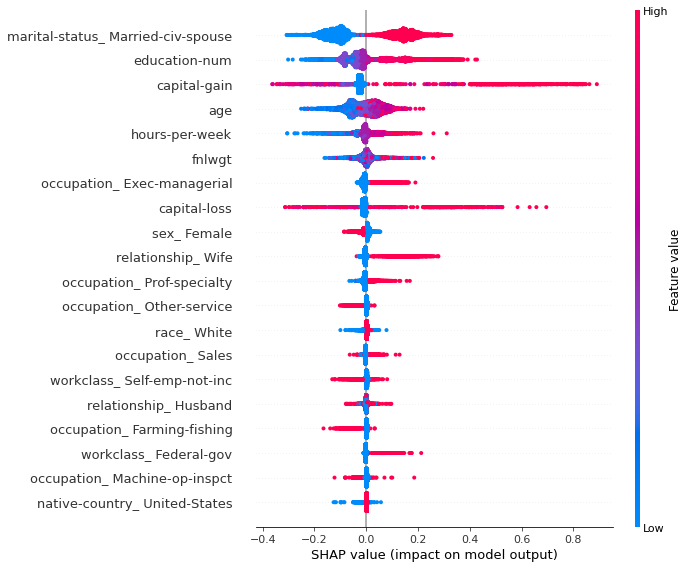

In [10]:
shap.summary_plot(shap_values_test, X_test)

#### Интерпретация:

- married - женатые люди зарабатывают больше неженатых, причем разделение по этому признаку очень четкое.
- education-num - видимо, годы обучения. Чем больше человек учился - тем больше зарабатывает. Все логично.
- capital gain, capital loss - странные признаки. На многих наблюдениях самые важные признаки, но при этом высокие значения влияют как в положительную, так и в отрицательную сторону. А низкие значения наоборот, не оказывают никакого влияния. Возможно, эти признаки влияют на итоговое решение в совокупности с другими признаками.
- age - Молодые люди явно получают меньше. Но дальше, один лишь возраст не гарантирует получение большей зарплаты. Этот вывод исходит из большого скопления высокого feature value возле нулевого значения Шепли. Лишь немногие становясь старше, гарантированно растут в доходах.
- hours-per-week - больше работаешь - больше получаешь. Тоже все логично.
- occupation-Exec managerial - Если человек исполнительный директор - он явно получает больше 50к. Если нет - то по разному, при этой фиче, равной нулю, она практически не влияет на итоговое предсказание

**Из интересных наблюдений:**
- В среднем женщины получают меньше мужчин (столбец sex_Female)
- Но при этом замужние женщины (relationship-Wife) уверенно получают больше 50к. Видимо, хорошие декретные в США
- не-белые и не из США получают скорее меньше 50к, чем больше

Отсортируем тестовый датасет по хорошему вещественному признаку - годам обучения. Возьмем топ 10% и посмотрим важность признаков на них.

In [11]:
X_test_top10_by_education_num = X_test.sort_values(by='education-num', ascending=False).iloc[:int(X_test.shape[0] * .1)]

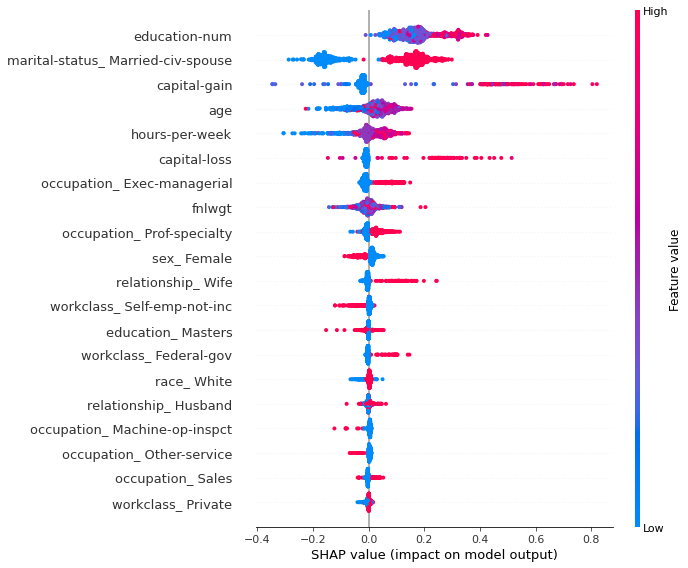

In [12]:
shap_values_test_top10 = explainer.shap_values(X_test_top10_by_education_num)
shap.summary_plot(shap_values_test_top10, X_test_top10_by_education_num)

В целом, важность практически для все признаков осталась примерно такой же. Но в совокупности с годами обучения, признаки прироста и оттока капитала стали более явно различимы. Вывод - образованные люди умеют и грамотно откладывать и грамотно тратить =)

Возьмем 3 случайных наблюдения и построим для них force_plot:

In [13]:
rand_indexes = [np.random.randint(0, int(X_test.shape[0])) for _ in range(3)]

In [14]:
shap.force_plot(explainer.expected_value, shap_values_test[rand_indexes[0],:], X_test.iloc[rand_indexes[0],:])

In [15]:
shap.force_plot(explainer.expected_value, shap_values_test[rand_indexes[1],:], X_test.iloc[rand_indexes[1],:])

In [16]:
shap.force_plot(explainer.expected_value, shap_values_test[rand_indexes[2],:], X_test.iloc[rand_indexes[2],:])

![](force_plot.jpg 'force_plot')

#### Интерпретация:

- Первое наблюдение: в положительную сторону этого человека "тянет" то, что он исполнительный директор и очень много работает, но перевешивает в обратную сторону то, что он не женат и мало учился - 9 лет.
- Второе наблюдение: "За" выступает только то, что женщина замужем, но ее в ноль перевешивают молодой возраст, недостаточное образование и малое количество часов работы.
- Третий человек. Из достоинств только то, что он из Гватемалы =) А дальше одни недостатки - не женат, всего 2 года образования, молодой возраст и т.д.